In [28]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_sample_image
from skimage import data
from sklearn.datasets import fetch_olivetti_faces
from skimage.transform import resize

In [29]:
def pca_from_scratch(X, n_components): 
    X = np.array(X, dtype=float)
    n_samples, n_features = X.shape

    mean = np.mean(X, axis=0)

    # Center the data
    X_centered = np.zeros_like(X)
    for i in range(n_samples):
        for j in range(n_features):
            X_centered[i][j] = X[i][j] - mean[j]

    # Compute the covariance matrix 
    cov_matrix = np.zeros((n_features, n_features))
    for i in range(n_features):
        for j in range(n_features):
            cov = 0
            for k in range(n_samples):
                cov += X_centered[k][i] * X_centered[k][j]
            cov_matrix[i][j] = cov / (n_samples - 1)

    # Compute eigenvalues and eigenvectors 
    def power_iteration(A, tol=1e-9, max_iter=10000):
        n = A.shape[0] 
        v = np.random.rand(n)
        v = v / np.linalg.norm(v)
        eigenvalue = 0

        for _ in range(max_iter):
            w = np.matmul(A, v)
            v_new = w / np.linalg.norm(w)
            eigenvalue_new = np.matmul(v_new.T, np.matmul(A, v_new))
            if abs(eigenvalue_new - eigenvalue) < tol:
                break
            v, eigenvalue = v_new, eigenvalue_new

        return eigenvalue_new, v_new

    # Get top n_components eigenpairs
    A = cov_matrix.copy()
    eigenvalues = []
    eigenvectors = np.zeros((n_features, n_components))

    for i in range(n_components):
        val, vec = power_iteration(A)
        vec = vec / np.linalg.norm(vec)
        eigenvalues.append(val)
        eigenvectors[:, i] = vec
        A = A - val * np.outer(vec, vec)

    eigenvalues = np.array(eigenvalues)

    # Sort eigenvalues & eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Project data (compression)
    X_compressed = np.zeros((n_samples, n_components))
    for i in range(n_samples):
        for j in range(n_components):
            val = 0
            for k in range(n_features):
                val += X_centered[i][k] * eigenvectors[k][j]
            X_compressed[i][j] = val

    # Reconstruct data (decompression)
    X_reconstructed = np.zeros((n_samples, n_features))
    for i in range(n_samples):
        for j in range(n_features):
            val = 0
            for k in range(n_components):
                val += X_compressed[i][k] * eigenvectors[j][k]
            X_reconstructed[i][j] = val + mean[j]

    return X_compressed, X_reconstructed, mean, cov_matrix, eigenvalues, eigenvectors

In [30]:
china = load_sample_image('china.jpg')   
reshaped_china = china.reshape(-1, 3)
print("Reshaped image shape:", reshaped_china.shape)

Reshaped image shape: (273280, 3)


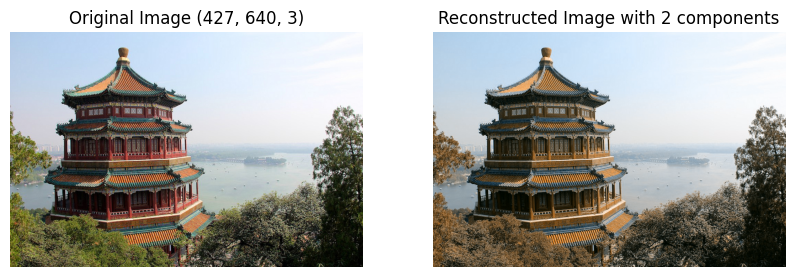

In [31]:
n_components = 2  
X = reshaped_china 

X_compressed, X_reconstructed, mean, cov, eigvals, eigvecs = pca_from_scratch(X, n_components)

reconstructed_image = X_reconstructed.reshape(china.shape)
reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(china)
plt.title(f"Original Image {reconstructed_image.shape}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image)
plt.title(f"Reconstructed Image with {n_components} components")
plt.axis('off')

plt.show()

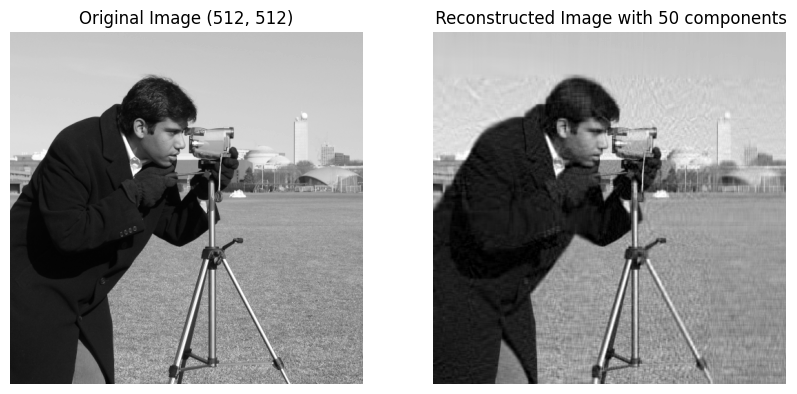

In [32]:
image = data.camera()  
X = image.copy()
X = X / 255.0  
X_flat = X  
n_components = 50
X_compressed, X_reconstructed, mean, cov, eigvals, eigvecs = pca_from_scratch(X_flat, n_components)

reconstructed = np.clip(X_reconstructed, 0, 1)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(X, cmap='gray')
plt.title(f"Original Image {image.shape}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed, cmap='gray')
plt.title(f" Reconstructed Image with {n_components} components")
plt.axis('off')
plt.show()

Reduced Faces shape: (50, 1024)


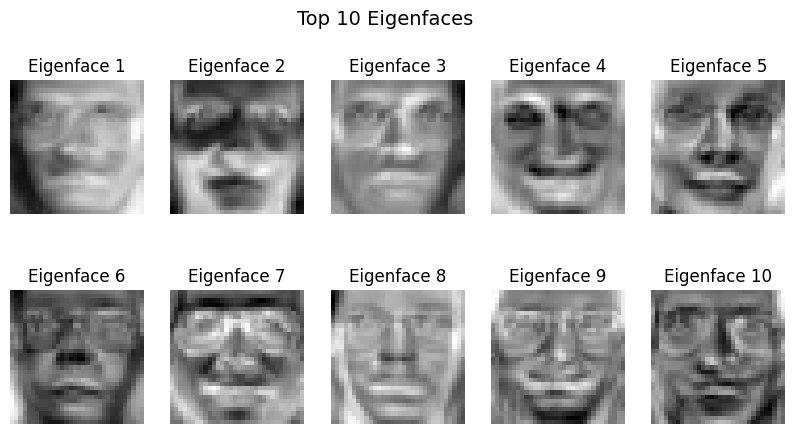

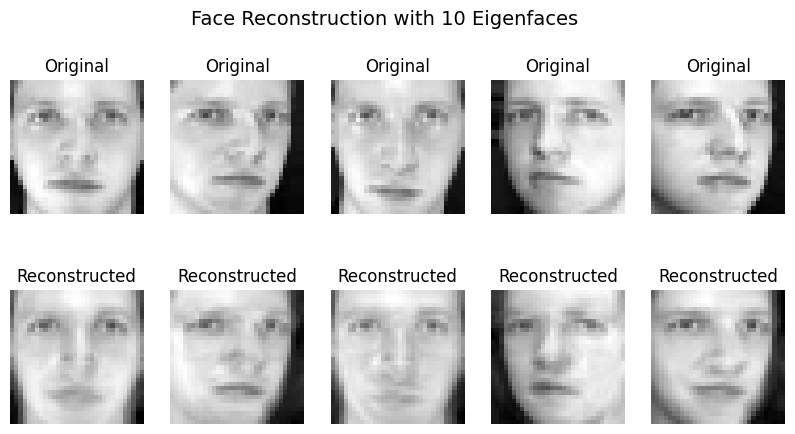

In [33]:
faces = fetch_olivetti_faces()
images = faces.images[:50]  

small_images = np.array([resize(img, (32, 32)) for img in images])
X = small_images.reshape(50, -1)
h, w = 32, 32

print("Reduced Faces shape:", X.shape)

n_components = 10
X_compressed, X_reconstructed, mean, cov, eigvals, eigvecs = pca_from_scratch(X, n_components)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(eigvecs[:, i].reshape(h, w), cmap='gray')
    plt.title(f"Eigenface {i+1}")
    plt.axis('off')
plt.suptitle("Top 10 Eigenfaces", fontsize=14)
plt.show()

plt.figure(figsize=(10, 5))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i].reshape(h, w), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, 5, i + 6)
    plt.imshow(X_reconstructed[i].reshape(h, w), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.suptitle(f"Face Reconstruction with {n_components} Eigenfaces", fontsize=14)
plt.show()
